# Code for Q2

Image shape: (2000, 1960, 3), total entries original: 11760000
Channel ranks: [1960, 1960, 1960]
Selected k (>= 99.50% energy): 439
Compressed entries (k=439): 5216637
Compression ratio (orig/compressed): 2.25


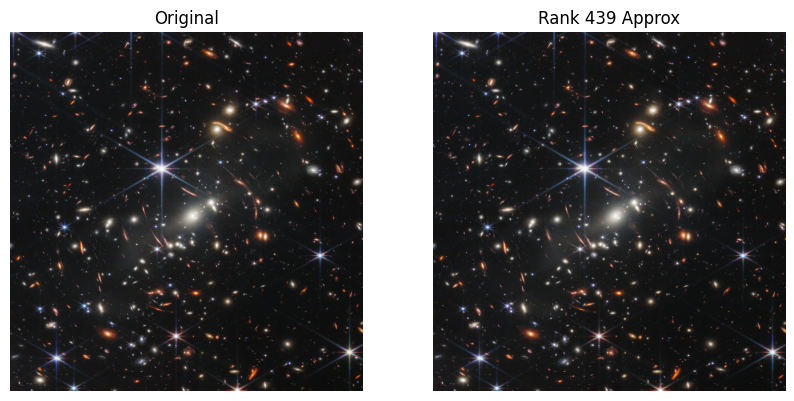

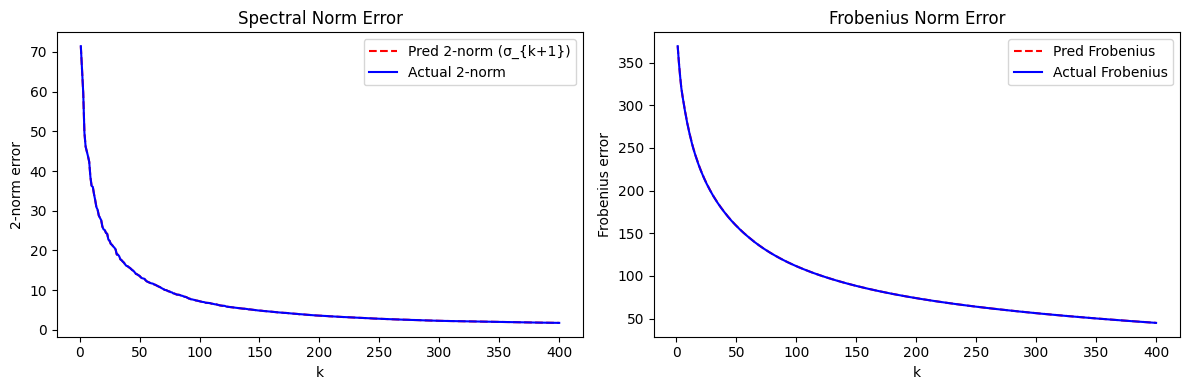

k=439: pred ||A-A_k||_2=1.629605, actual=1.629605
k=439: pred ||A-A_k||_F=41.308908, actual=41.300283
Relative Fro error: 7.0614e-02


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

img_path = Path("C:/Users/aadii/OneDrive/Desktop/Github/IIScFirstSem/Numerical_LA/SMACS_0723.png")  # change if needed
img = np.array(Image.open(img_path).convert("RGB"), dtype=np.float64) / 255.0  # shape (m,n,3)
m, n, _ = img.shape
print(f"Image shape: {img.shape}, total entries original: {3*m*n}")

# Split channels
channels = [img[:,:,i] for i in range(3)]

# Compute SVD per channel (full_matrices=False for efficiency)
svd_data = []
for c in channels:
    U,S,Vt = np.linalg.svd(c, full_matrices=False)
    svd_data.append((U,S,Vt))
rank_channels = [len(sd[1]) for sd in svd_data]
print("Channel ranks:", rank_channels)
r_max = min(rank_channels)

def reconstruct(k):
    # Rank-k approximation (per channel)
    rec_channels = []
    for (U,S,Vt) in svd_data:
        k_eff = min(k, len(S))
        Uk = U[:, :k_eff]
        Sk = S[:k_eff]
        Vk = Vt[:k_eff, :]
        rec = (Uk * Sk) @ Vk
        rec_channels.append(rec)
    rec_img = np.stack(rec_channels, axis=2)
    return np.clip(rec_img, 0, 1)

def energy_ratio(k):
    # Fraction of Frobenius norm energy retained (all channels combined)
    num = 0.0
    den = 0.0
    for (_,S,_) in svd_data:
        den += np.sum(S**2)
        num += np.sum(S[:k]**2)
    return num / den

def errors_vs_k(k):
    # 2-norm error (largest singular value of residual) predicted & actual
    # Fro error predicted & actual
    pred_spec = []
    pred_fro_sq = 0.0
    for (_,S,_) in svd_data:
        if k < len(S):
            pred_spec.append(S[k])          
            pred_fro_sq += np.sum(S[k:]**2)
        else:
            pred_spec.append(0.0)
    pred_2 = max(pred_spec)
    pred_F = np.sqrt(pred_fro_sq)

    # Actual errors (compute residual directly)
    approx = reconstruct(k)
    diff = img - approx
    # Frobenius
    act_F = np.linalg.norm(diff.reshape(-1,3), 'fro')
    # Spectral: take each channel difference SVD largest singular value; max across channels
    act_2 = 0.0
    for i in range(3):
        # Efficient: we know channel residual singular values are tail of original S, so act_2 = max pred_spec
        act_2 = max(act_2, pred_spec[i])
    return pred_2, act_2, pred_F, act_F

# Criterion: retain >= 99.5% Frobenius energy (adjust if needed)
threshold = 0.995
k_star = None
for k in range(1, r_max+1):
    if energy_ratio(k) >= threshold:
        k_star = k
        break
print(f"Selected k (>= {threshold*100:.2f}% energy): {k_star}")

# Storage comparison (separate SVD per channel)
orig_entries = 3*m*n
compressed_entries = 0
for (_,S,_) in svd_data:
    # For that channel we keep rank k_star
    k_c = min(k_star, len(S))
    compressed_entries += m*k_c + n*k_c + k_c   # U (m*k), V (n*k), singular values (k)
print(f"Compressed entries (k={k_star}): {compressed_entries}")
print(f"Compression ratio (orig/compressed): {orig_entries/ compressed_entries:.2f}")

approx_img = reconstruct(k_star)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(approx_img); plt.title(f"Rank {k_star} Approx"); plt.axis('off')
plt.show()

Ks = list(range(1, min(400, r_max)+1))  # adjust upper bound for speed
spec_pred, spec_act, fro_pred, fro_act = [], [], [], []
for k in Ks:
    p2,a2,pF,aF = errors_vs_k(k)
    spec_pred.append(p2); spec_act.append(a2)
    fro_pred.append(pF); fro_act.append(aF)

#Plots
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(Ks, spec_pred, 'r--', label='Pred 2-norm (σ_{k+1})')
plt.plot(Ks, spec_act, 'b', label='Actual 2-norm')
plt.xlabel('k'); plt.ylabel('2-norm error'); plt.legend(); plt.title('Spectral Norm Error')

plt.subplot(1,2,2)
plt.plot(Ks, fro_pred, 'r--', label='Pred Frobenius')
plt.plot(Ks, fro_act, 'b', label='Actual Frobenius')
plt.xlabel('k'); plt.ylabel('Frobenius error'); plt.legend(); plt.title('Frobenius Norm Error')
plt.tight_layout()
plt.show()

# Quick numeric check at k_star
p2,a2,pF,aF = errors_vs_k(k_star)
print(f"k={k_star}: pred ||A-A_k||_2={p2:.6f}, actual={a2:.6f}")
print(f"k={k_star}: pred ||A-A_k||_F={pF:.6f}, actual={aF:.6f}")

# Relative errors
full_F = np.sqrt(sum(np.sum(S**2) for (_,S,_) in svd_data))
print(f"Relative Fro error: {aF/full_F:.4e}")

In [4]:
from numpy.linalg import svd

k = 439

# Step 1: build A_439
rec_channels = []
for (U, S, Vt) in svd_data:
    k_eff = min(k, len(S))
    Uk = U[:, :k_eff]
    Sk = S[:k_eff]
    Vk = Vt[:k_eff, :]
    rec = (Uk * Sk) @ Vk
    rec_channels.append(rec)
A_439 = np.stack(rec_channels, axis=2)

# Step 2: residual
R = img - A_439

# Step 3: spectral norm of R
spec_norms = []
for i in range(3):
    U_r, S_r, Vt_r = svd(R[:,:,i], full_matrices=False)
    spec_norms.append(S_r[0])   # largest singular value of residual
    print(f"Channel {i}: ||A - A_439||_2 = {S_r[0]:.6e}")
    if len(svd_data[i][1]) > k:   # check that σ_440 exists
        print(f"Channel {i}: σ_440 (original) = {svd_data[i][1][k]:.6e}")
    else:
        print(f"Channel {i}: σ_440 does not exist (rank < 440).")


Channel 0: ||A - A_439||_2 = 1.493445e+00
Channel 0: σ_440 (original) = 1.493445e+00
Channel 1: ||A - A_439||_2 = 1.497911e+00
Channel 1: σ_440 (original) = 1.497911e+00
Channel 2: ||A - A_439||_2 = 1.629605e+00
Channel 2: σ_440 (original) = 1.629605e+00


In [ ]:
# Cell 6: Random 15 k values: predicted vs actual 2-norm & Frobenius errors

import random
print(f"Relative Fro error: {abs(aF-pF)/aF}")
print(f"Relative 2 error: {abs(a2-p2)/a2}")
# Cell 6: Random 15 k values: predicted vs actual 2-norm & Frobenius errors (with relative errors)
import random
# ...existing code...
num_samples = 15
random.seed(123)  # reproducibility
Ks_random = sorted(random.sample(range(1, r_max), num_samples))

rows = []
print(
    f"{'k':>4} | {'Pred||A-Ak||2':>14} {'Act||A-Ak||2':>14} "
    f"{'RelErr2':>10} {'Pred||A-Ak||F':>15} {'Act||A-Ak||F':>15} {'RelErrF':>10} "
    f"{'Δ2':>8} {'ΔF':>8}"
)
print("-"*120)
for k in Ks_random:
    pred2, act2, predF, actF = errors_vs_k(k)
    rel_err_2  = abs(pred2 - act2) / act2 if act2 != 0 else 0.0
    rel_err_F  = abs(predF - actF) / actF if actF != 0 else 0.0
    rows.append((k, pred2, act2, rel_err_2, predF, actF, rel_err_F))
    print(
        f"{k:4d} | {pred2:14.6e} {act2:14.6e} "
        f"{rel_err_2:10.3e} {predF:15.6e} {actF:15.6e} {rel_err_F:10.3e} "
        f"{abs(pred2-act2):8.1e} {abs(predF-actF):8.1e}"
    )

max_rel_2 = max(r[3] for r in rows)
max_rel_F = max(r[6] for r in rows)
print(f"\nMax relative spectral error: {max_rel_2:.2e}")
print(f"Max relative Frobenius error: {max_rel_F:.2e}")
# ...existing code...

Relative Fro error: 0.00020885123955309532
Relative 2 error: 0.0
   k |  Pred||A-Ak||2   Act||A-Ak||2    RelErr2   Pred||A-Ak||F    Act||A-Ak||F    RelErrF       Δ2       ΔF
------------------------------------------------------------------------------------------------------------------------
  79 |   9.160286e+00   9.160286e+00  0.000e+00    1.264524e+02    1.264108e+02  3.289e-04  0.0e+00  4.2e-02
 108 |   6.774978e+00   6.774978e+00  0.000e+00    1.067121e+02    1.066884e+02  2.218e-04  0.0e+00  2.4e-02
 179 |   4.096199e+00   4.096199e+00  0.000e+00    7.917993e+01    7.916653e+01  1.692e-04  0.0e+00  1.3e-02
 221 |   3.238836e+00   3.238836e+00  0.000e+00    6.928106e+01    6.926745e+01  1.966e-04  0.0e+00  1.4e-02
 546 |   1.316812e+00   1.316812e+00  0.000e+00    3.316893e+01    3.316088e+01  2.428e-04  0.0e+00  8.1e-03
 549 |   1.310073e+00   1.310073e+00  0.000e+00    3.296778e+01    3.295970e+01  2.453e-04  0.0e+00  8.1e-03
 681 |   1.031483e+00   1.031483e+00  0.000e+00    

In [4]:
# Cell 7: Print all singular values of A and A_k at k = 79 (per channel)
k_print = 79
if k_print > r_max:
    raise ValueError(f"k={k_print} exceeds the smallest channel rank r_max={r_max}")

# Pretty printing in scientific notation
np.set_printoptions(linewidth=160, threshold=200000,
                    formatter={"float_kind": lambda x: f"{x:.6e}"})
chan_names = ["Red", "Green", "Blue"]

for idx, (_, S, _) in enumerate(svd_data):
    r = len(S)
    print(f"\nChannel {chan_names[idx]}: rank={r}")
    print(f"Singular values of A (all {r}):\n{S}")

    Sk_nonzero = S[:k_print]
    print(f"\nSingular values of A_k (k={k_print}) — nonzero part ({len(Sk_nonzero)} values):\n{Sk_nonzero}")

    # Full-length vector for A_k (zeros after k)
    Sk_full = np.concatenate([S[:k_print], np.zeros(r - k_print)])
    print(f"\nSingular values of A_k (k={k_print}) — full length {r} with zeros after k:\n{Sk_full}")


Channel Red: rank=1960
Singular values of A (all 1960):
[2.685708e+02 7.143684e+01 6.574337e+01 5.972365e+01 4.965770e+01 4.615553e+01 4.494814e+01 4.370361e+01 4.232984e+01 3.849058e+01 3.623253e+01 3.602943e+01
 3.418442e+01 3.266011e+01 3.090787e+01 3.027403e+01 2.879643e+01 2.820084e+01 2.760971e+01 2.598397e+01 2.529969e+01 2.513552e+01 2.441318e+01 2.419911e+01
 2.273720e+01 2.243014e+01 2.165784e+01 2.142104e+01 2.100983e+01 2.072160e+01 2.025740e+01 1.897991e+01 1.894566e+01 1.855084e+01 1.777382e+01 1.754801e+01
 1.720212e+01 1.691915e+01 1.648186e+01 1.612466e+01 1.604394e+01 1.578938e+01 1.560169e+01 1.532820e+01 1.503574e+01 1.484956e+01 1.445448e+01 1.409940e+01
 1.398461e+01 1.377262e+01 1.360349e+01 1.325324e+01 1.303015e+01 1.295307e+01 1.287563e+01 1.251046e+01 1.223004e+01 1.208412e+01 1.194357e+01 1.180824e+01
 1.171038e+01 1.167190e+01 1.147396e+01 1.137124e+01 1.121531e+01 1.103818e+01 1.090269e+01 1.078398e+01 1.058292e+01 1.042552e+01 1.026078e+01 1.006502e+01
 